In [255]:
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt
import geopandas as gpd 
from modules import preprocess
from scipy.stats import gamma, norm

number_to_month = {1: "jan", 2: "feb", 3: "mar", 4: "apr", 5: "may", 6: "june", 7: "july", 8: "aug", 9: "sep", 10: "oct", 11: "nov", 12: "dec"} 

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Data import

#### Define the study crop and country

In [250]:
# USER INPUTS
ecmwf_country = "BR" # one of ["US", "BR"]
crop = "wheat" # one of ["maize", "wheat"]

shapefile_path, crop_season_in_days_of_year, crop_season_in_months, crop_season_in_time_steps = preprocess.set_crop_season(ecmwf_country, crop)

print(crop, ecmwf_country, crop_season_in_days_of_year, crop_season_in_months, crop_season_in_time_steps)

wheat BR (129, 329) (5, 11) (16, 41)


#### Read Data

<Axes: >

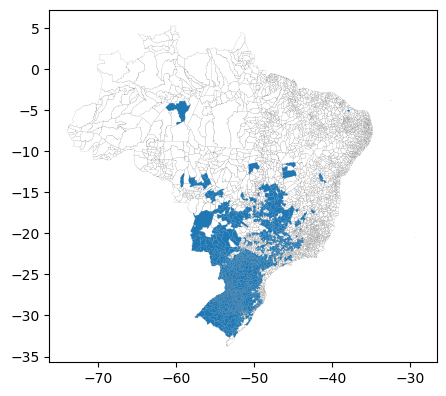

In [251]:
# CY-BENCH
yield_data = pd.read_csv("../data/CY-Bench/{}/{}/yield_{}_{}.csv".format(ecmwf_country, crop, crop, ecmwf_country))
era = pd.read_csv("../data/CY-Bench/{}/{}/meteo_{}_{}.csv".format(ecmwf_country, crop, crop, ecmwf_country))
relevant_adm_ids = yield_data["adm_id"].unique()

# Country shapefile
country_gpd = gpd.read_file(shapefile_path)
country_gpd = country_gpd.set_crs("EPSG:4326", allow_override=True) # allow override because US shapefile is already in 4326
country_gpd["adm_id"] = ""
if ecmwf_country == "US":
    country_gpd["adm_id"] = "{}-".format(ecmwf_country) + country_gpd["STATEFP"].astype(str) + "-" + country_gpd["COUNTYFP"].astype(str)
if ecmwf_country == "BR":
    country_gpd["adm_id"] = country_gpd["ADM2_PCODE"]
mismatches = [adm_id for adm_id in relevant_adm_ids if adm_id not in country_gpd["adm_id"].unique()]
country_gpd_crop = country_gpd.loc[country_gpd["adm_id"].isin(relevant_adm_ids)].reset_index(drop=True)
country_gpd_shape = country_gpd_crop.dissolve().to_crs("EPSG:4326")
base = country_gpd.plot(color="white", edgecolor="black", linewidth=.05, figsize=(5, 5))
country_gpd_crop.plot(ax=base)

#### Resample ERA to match 8-day bins

In [252]:
era = preprocess.filter_predictors_by_adm_ids([era], relevant_adm_ids)[0]
era = preprocess.assign_date_and_year_columns(era)
era = preprocess.filter_predictors_by_crop_season(era, crop_season_in_days_of_year[0], crop_season_in_days_of_year[1])
era_resampled = preprocess.resample_era(era)
era_resampled.sample(5)

,adm_id,harvest_year,start_date_bin,tmin,tmax,prec,tavg,time_step
48097,BR3134301,2004,2004-11-08,15.857525,25.630620,0.522496,20.569414,39
717313,BR4316428,2018,2018-11-25,15.233217,26.454090,0.000000,21.160239,41
570362,BR4302600,2016,2016-05-08,14.169801,20.963025,6.130000,17.291024,16
58966,BR3143401,2023,2023-11-17,20.499437,29.123917,4.622662,23.514454,40
643799,BR4310413,2005,2005-08-21,12.694513,23.274339,2.362500,17.060590,29


## 2. Bring ERA and ECMWF together

Seasonal climate models (SCM) from ECMWF are initialized at the first of each month from January to December. The forecasts are provided for 7 months ahead. In-season yield forecasts will be validated throughout the season each time a new ECMWF forecasts is available at the beginning of each month. Below is an illustration of how ERA and SCM data will be concatenated depending on the month of initialization. Furthermore, since forecast length is up to 7 month, in-season yield forecast validation will start earliest 7 month before harvest. All past months will be consecutively supplemented wit AgERA5 data from CY-Bench each month as harvest is approached. See example wheat cropping season in Brazil from May to November (green dashed line) and in the US (blue dashed line) in the image below. For now, we will build the dataset from which crop calendars of arbitrary length (max. 7 month) can be extracted.


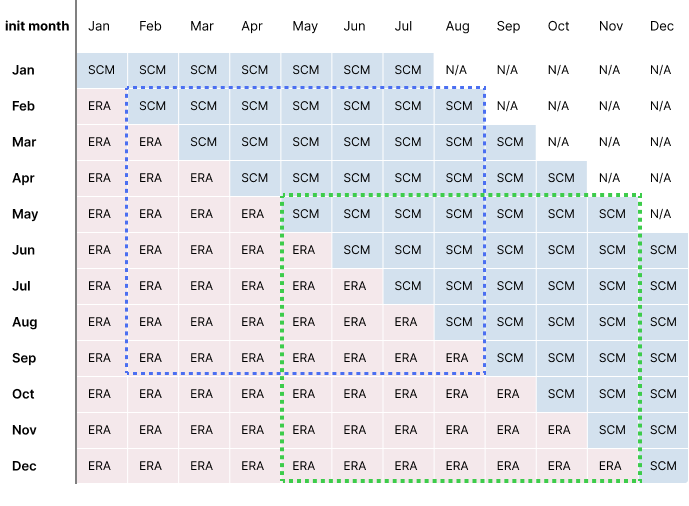

In [253]:
from IPython.display import Image
Image(filename="era_scm_us_br_overview.png")

In [254]:
ecmwf = pd.read_csv("../data/ECMWF/{}/ecmwf_csv/ecmwf_{}.csv".format(ecmwf_country, number_to_month[10]))
ecmwf = preprocess.format_ecmwf_columns(ecmwf)
ecmwf = preprocess.filter_by_crop_season(ecmwf, crop_season_in_days_of_year)
ecmwf = preprocess.resample_ecmwf(ecmwf, crop_season_in_days_of_year)
ecmwf, first_time_step = preprocess.assign_ecmwf_forecasts_to_adm_units(ecmwf, country_gpd_crop)

In [256]:
# Bias correction
def normal_correction(obs_data, mod_data, sce_data, cdf_threshold=0.9999999):
    obs_len, mod_len, sce_len = [len(x) for x in [obs_data, mod_data, sce_data]]
    obs_mean, mod_mean, sce_mean = [x.mean() for x in [obs_data, mod_data, sce_data]]
    
    obs_norm, mod_norm, sce_norm = [
        norm.fit(x) for x in [obs_data, mod_data, sce_data]
    ]
    
    sce_norm = list(sce_norm)
    sce_norm[1] += 1e-5
    sce_norm = tuple(sce_norm)
    
    #print(*sce_norm)
    
    obs_cdf = norm.cdf(np.sort(obs_data), *obs_norm)
    mod_cdf = norm.cdf(np.sort(mod_data), *mod_norm)
    sce_cdf = norm.cdf(np.sort(sce_data), *sce_norm)

    obs_cdf = np.maximum(np.minimum(obs_cdf, cdf_threshold), 1 - cdf_threshold)
    mod_cdf = np.maximum(np.minimum(mod_cdf, cdf_threshold), 1 - cdf_threshold)
    sce_cdf = np.maximum(np.minimum(sce_cdf, cdf_threshold), 1 - cdf_threshold)

    sce_argsort = np.argsort(sce_data)

    obs_cdf_intpol = np.interp(
        np.linspace(1, obs_len, sce_len), np.linspace(1, obs_len, obs_len), obs_cdf
    )
    mod_cdf_intpol = np.interp(
        np.linspace(1, mod_len, sce_len), np.linspace(1, mod_len, mod_len), mod_cdf
    )
    obs_cdf_shift, mod_cdf_shift, sce_cdf_shift = [
        (x - 0.5) for x in [obs_cdf_intpol, mod_cdf_intpol, sce_cdf]
    ]

    obs_inverse, mod_inverse, sce_inverse = [
        1.0 / (0.5 - np.abs(x)) for x in [obs_cdf_shift, mod_cdf_shift, sce_cdf_shift]
    ]

    adapted_cdf = np.sign(obs_cdf_shift) * (
        1.0 - 1.0 / (obs_inverse * sce_inverse / mod_inverse)
    )
    adapted_cdf[adapted_cdf < 0] += 1.0
    adapted_cdf = np.maximum(np.minimum(adapted_cdf, cdf_threshold), 1 - cdf_threshold)

    xvals = norm.ppf(np.sort(adapted_cdf), *obs_norm) + obs_norm[-1] / mod_norm[-1] * (
        norm.ppf(sce_cdf, *sce_norm) - norm.ppf(sce_cdf, *mod_norm)
    )

    xvals -= xvals.mean()
    xvals += obs_mean + (sce_mean - mod_mean)

    correction = np.zeros(sce_len)
    correction[sce_argsort] = xvals

    return correction

In [258]:
era_pivot = preprocess.pivot_era(era_resampled.loc[era_resampled["time_step"] >= first_time_step])

In [260]:
br_test_years = [2006, 2015, 2017]

In [276]:
ecmwf_reference = ecmwf.loc[ecmwf["harvest_year"].isin(br_test_years) == False].sort_values(by=["adm_id", "harvest_year"]).reset_index(drop=True).copy()
era_reference = preprocess.pivot_era(era_resampled.loc[era_resampled["time_step"] >= first_time_step]).copy()
era_reference = era_reference.loc[era_reference["harvest_year"].isin(br_test_years) == False].sort_values(by=["adm_id", "harvest_year"]).reset_index(drop=True)

In [293]:
features = [c for c in ecmwf_reference.columns  if ("prec"in c) or ("tavg" in c) or ("tmin" in c) or ("tmax" in c)]
#ecmwf_groups_reference = ecmwf_reference.groupby(["adm_id"])
#ecmwf_groups_adjusted = ecmwf.copy()
#ecmwf_groups_adjusted[features] = np.nan

for adm_id in relevant_adm_ids:
    for col in features:
        ecmwf_reference_year_adm_id_feature = ecmwf_reference.loc[(ecmwf_reference["adm_id"] == adm_id), [col, "harvest_year"]]
        era_reference_year_adm_id_feature = era_reference.loc[(era_reference["adm_id"] == adm_id), [col, "harvest_year"]]
        
        print(ecmwf_reference_year_adm_id_feature)

      tavg_35  harvest_year
0   25.446592          2003
1   25.456825          2004
2   25.177257          2005
3   25.205977          2007
4   25.123818          2008
5   26.191762          2009
6   26.172198          2010
7   25.545181          2011
8   25.765649          2012
9   25.235671          2013
10  25.330400          2014
11  25.971657          2016
12  26.040449          2018
13  25.448208          2019
14  26.215236          2020
15  25.646380          2021
16  26.261338          2022
17  29.254881          2023
      tavg_36  harvest_year
0   25.489319          2003
1   25.988738          2004
2   25.597105          2005
3   25.167260          2007
4   25.546734          2008
5   25.874168          2009
6   25.835822          2010
7   25.134730          2011
8   25.610096          2012
9   25.481445          2013
10  25.372118          2014
11  26.332653          2016
12  25.896295          2018
13  25.689208          2019
14  26.378402          2020
15  26.356346       

KeyboardInterrupt: 

In [ ]:
era_pivot = preprocess.pivot_era(era_resampled.loc[era_resampled["time_step"] < first_time_step])
era_ecmwf = era_pivot.merge(ecmwf, on=["adm_id", "harvest_year"], how="right")

In [244]:
li = []
for month in range(list(crop_season_in_months)[0], list(crop_season_in_months)[1]+1):
    ecmwf = pd.read_csv("../data/ECMWF/{}/ecmwf_csv/ecmwf_{}.csv".format(ecmwf_country, number_to_month[month]))
    ecmwf = preprocess.format_ecmwf_columns(ecmwf)
    ecmwf = preprocess.filter_by_crop_season(ecmwf, crop_season_in_days_of_year)
    ecmwf = preprocess.resample_ecmwf(ecmwf, crop_season_in_days_of_year)
    ecmwf, first_time_step = preprocess.assign_ecmwf_forecasts_to_adm_units(ecmwf, country_gpd_crop)
    era_pivot = preprocess.pivot_era(era_resampled.loc[era_resampled["time_step"] < first_time_step])
    era_ecmwf = era_pivot.merge(ecmwf, on=["adm_id", "harvest_year"], how="right")
    li.append(era_ecmwf)

era_end_of_season = preprocess.create_end_of_season(era_resampled, crop_season_in_months)
li.append(era_end_of_season)
era_ecmwf = pd.concat(li, ignore_index=True)
era_ecmwf.sample(5)

,adm_id,init_date,tavg_4,tavg_5,tavg_6,tavg_7,tavg_8,tavg_9,tavg_10,tavg_11,...,prec_21,prec_22,prec_23,prec_24,prec_25,prec_26,prec_27,prec_28,prec_29,harvest_year
305028,US-54-003,2006-07-01,1.929736,1.746402,-0.524955,0.562819,10.147597,3.308821,4.936168,11.165197,...,6.785610,8.381027,3.243317,3.669663,4.131320,3.603218,4.283791,3.467853,2.995887,2006
251625,US-49-049,2006-06-01,-2.421002,-6.298143,-5.633727,2.765469,-1.200034,0.475300,2.954027,4.774608,...,0.157833,0.143184,0.325333,0.304801,0.414655,0.650605,1.063543,0.738103,0.538048,2006
146237,US-48-219,2017-04-01,10.073092,10.554489,13.120843,12.227072,13.132834,19.125979,14.910428,13.556077,...,1.740594,1.569126,1.661411,1.355939,1.228495,0.994245,1.420008,1.897813,1.811218,2017
255321,US-55-085,2006-06-01,-8.604766,-10.395390,-10.987531,-7.350159,0.127648,-5.840443,-0.035286,4.783564,...,2.577268,3.932990,3.019216,3.294912,3.450354,1.947485,3.076406,3.325460,2.818091,2006
24438,US-29-175,2018-02-01,-1.607661,4.777228,7.307263,5.912061,7.690183,9.781809,10.957786,13.202116,...,3.119631,3.005800,3.020538,1.646041,2.024338,1.692984,2.040000,1.978080,2.486601,2018


In [247]:
era_ecmwf

,adm_id,init_date,tavg_4,tavg_5,tavg_6,tavg_7,tavg_8,tavg_9,tavg_10,tavg_11,...,prec_21,prec_22,prec_23,prec_24,prec_25,prec_26,prec_27,prec_28,prec_29,harvest_year
0,US-01-001,2003-02-01,8.405354,10.413559,11.027039,11.715356,12.007045,13.315905,13.294445,15.730419,...,4.067534,3.833387,3.746650,3.581338,3.771593,3.040470,5.508212,2.957108,3.739068,2003
1,US-01-001,2004-02-01,8.601390,7.924708,8.402340,12.013003,13.391968,13.751691,14.828059,15.161063,...,3.808006,3.138775,2.526870,3.298930,3.494450,3.923669,4.368406,3.855492,4.302208,2004
2,US-01-001,2005-02-01,9.652364,11.685500,9.132589,11.993255,13.727556,13.299029,14.784250,15.415214,...,4.489325,3.876331,4.259044,3.388338,3.849738,4.965512,3.022157,3.395718,3.831912,2005
3,US-01-001,2006-02-01,8.822753,6.058418,8.790378,11.955924,12.369641,14.608071,15.905769,17.230265,...,2.602979,3.573031,3.634350,4.553807,4.274801,4.563991,4.017200,3.208346,4.585199,2006
4,US-01-001,2007-02-01,5.337969,7.241220,10.031896,12.064755,12.988509,14.621491,14.928503,15.536830,...,3.678944,2.937075,3.641613,3.956825,3.553294,3.531456,3.574125,4.324481,3.253119,2007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410083,US-56-045,2019-09-01,-11.526240,-9.367476,-12.089108,-11.889841,-3.669708,-0.470801,3.724012,4.077792,...,2.403351,2.576767,3.433369,2.424671,4.925528,0.995667,2.976213,1.063876,0.378696,2019
410084,US-56-045,2020-09-01,-7.861302,-6.916794,-6.377570,-2.214811,2.138315,-2.814271,2.031234,-0.304141,...,0.809332,1.052246,1.358901,1.924386,1.260477,3.054896,1.140857,0.085947,0.111494,2020
410085,US-56-045,2021-09-01,-11.136647,-19.219705,-5.704684,-0.788224,1.890271,-0.958532,1.597386,5.921205,...,3.214194,3.135853,1.496589,2.132159,0.271462,0.669375,0.544690,1.983081,0.179655,2021
410086,US-56-045,2022-09-01,-4.295168,-3.458280,-11.515050,0.408230,-7.906287,3.737161,4.174163,1.435600,...,1.052263,1.361587,3.102027,0.673828,2.677372,0.086277,1.469378,2.127834,0.002203,2022


In [249]:
era_ecmwf.to_csv("../data/preprocessed/{}/ecmwf_era_{}_{}.csv".format(ecmwf_country, crop, ecmwf_country))